In [48]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
def get_target_label_idx(labels, targets, shots=5, test=False):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    final_list = []
    
    for t in targets:
        if test:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
        else:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()[:shots]
    
    return final_list

In [94]:
# function to convert labels [5,6,7,8,9] to [0,1,2,3,4]
def convert_label(x):

    if x >= 5:
        return x-5
    else:
        return x

In [80]:
from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST

import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):

    def __init__(self, root: str, normal_class=[5,6,7,8,9], shots=5):
        super().__init__()

        self.root = root
        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple(normal_class)
        self.outlier_classes = list(range(0, 10))
        self.outlier_classes = [item for item in self.outlier_classes if item not in self.normal_classes]
#         self.outlier_classes.remove(normal_class)
        print("classes: ", self.normal_classes)
#         # MNIST preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        transform = transforms.Compose([transforms.ToTensor()])

#         target_transform = transforms.Lambda(lambda x: int(x in self.normal_classes))
        
        target_transform = transforms.Lambda(lambda x: convert_label(x))
        train_set = MyMNIST(root=self.root, train=True, download=True,
                            transform=transform, target_transform=target_transform)
        # Subset train_set to normal class
        train_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes, shots=shots)
        self.train_set = Subset(train_set, train_idx_normal)

        test_set = MyMNIST(root=self.root, train=False, download=True,
                                transform=transform, target_transform=target_transform)
        
        test_idx_normal = get_target_label_idx(test_set.test_labels.clone().data.cpu().numpy(), self.normal_classes, test=True)
        self.test_set = Subset(test_set, test_idx_normal)

    

        
        

class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed



In [81]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 5)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [82]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in train_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
            else:
                
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in test_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

classes:  (5, 6, 7, 8, 9)
Labels:  tensor([3, 4, 1, 2, 0])


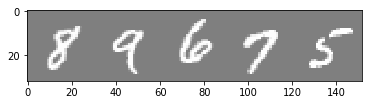

In [97]:
mninst_dataset = MNIST_Dataset(root='data/', shots=5)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, idx = dataiter.next()
print("Labels: ", labels)

# show images
imshow(torchvision.utils.make_grid(images))
    

In [86]:
# pretraining model
mninst_dataset = MNIST_Dataset(root='data/', normal_class=[5,6,7,8,9] ,shots=1000)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
train_size =  len(mninst_dataset.train_set)
test_size = len(mninst_dataset.test_set)

net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

classes:  (5, 6, 7, 8, 9)
Epoch 0/199
----------
Train Loss: 1.6107 Acc: 0.2000
Val Loss: 1.6073 Acc: 0.2076

Epoch 1/199
----------
Train Loss: 1.6085 Acc: 0.2022
Val Loss: 1.6058 Acc: 0.2181

Epoch 2/199
----------
Train Loss: 1.6065 Acc: 0.2630
Val Loss: 1.6040 Acc: 0.3145

Epoch 3/199
----------
Train Loss: 1.6046 Acc: 0.3208
Val Loss: 1.6023 Acc: 0.3573

Epoch 4/199
----------
Train Loss: 1.6025 Acc: 0.3546
Val Loss: 1.6001 Acc: 0.3919

Epoch 5/199
----------
Train Loss: 1.5999 Acc: 0.3922
Val Loss: 1.5972 Acc: 0.4392

Epoch 6/199
----------
Train Loss: 1.5962 Acc: 0.4306
Val Loss: 1.5927 Acc: 0.5106

Epoch 7/199
----------
Train Loss: 1.5908 Acc: 0.4414
Val Loss: 1.5860 Acc: 0.5377

Epoch 8/199
----------
Train Loss: 1.5824 Acc: 0.5258
Val Loss: 1.5750 Acc: 0.5937

Epoch 9/199
----------
Train Loss: 1.5677 Acc: 0.6112
Val Loss: 1.5549 Acc: 0.6075

Epoch 10/199
----------
Train Loss: 1.5386 Acc: 0.5924
Val Loss: 1.5122 Acc: 0.6151

Epoch 11/199
----------
Train Loss: 1.4693 Acc: 0

Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 97/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 98/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 99/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 100/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 101/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 102/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 103/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 104/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 105/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 106/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 107/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.91

Val Loss: 0.2742 Acc: 0.9159

Epoch 192/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 193/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 194/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 195/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 196/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 197/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 198/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Epoch 199/199
----------
Train Loss: 0.2555 Acc: 0.9194
Val Loss: 0.2742 Acc: 0.9159

Training complete in 5m 14s
Best val Acc: 0.916067


In [87]:
# Saving the pretrained model
torch.save(best_net, 'LeNet_5_class_pretrained_model.tar')

/home/haal01/Desktop/Projects/deep-svdd-env/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [92]:
shot_list = [5, 10, 15, 20, 25, 30] # no of images per class 
n_epochs = 20
best_net_dict = {}
best_acc_list = []
for shot in shot_list:
    
    mninst_dataset = MNIST_Dataset(root='data/', normal_class=[0,1,2,3,4], shots=shot)
    train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)
    test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
    train_size =  len(mninst_dataset.train_set)
    test_size = len(mninst_dataset.test_set)
    
#     net = LeNet().to(device)
# loading pretrained model
    net = torch.load('LeNet_5_class_pretrained_model.tar')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n_epochs)
    
    best_acc_list.append(best_acc.item())
    best_net_dict.update({shot : best_net})

classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 2.5677 Acc: 0.3600
Val Loss: 3.0720 Acc: 0.3966

Epoch 1/19
----------
Train Loss: 1.8615 Acc: 0.4800
Val Loss: 2.2230 Acc: 0.4312

Epoch 2/19
----------
Train Loss: 1.6933 Acc: 0.4800
Val Loss: 2.3014 Acc: 0.5633

Epoch 3/19
----------
Train Loss: 1.2780 Acc: 0.6800
Val Loss: 1.3240 Acc: 0.5357

Epoch 4/19
----------
Train Loss: 0.8697 Acc: 0.6400
Val Loss: 1.6447 Acc: 0.6188

Epoch 5/19
----------
Train Loss: 0.6996 Acc: 0.7200
Val Loss: 1.0363 Acc: 0.6659

Epoch 6/19
----------
Train Loss: 0.5100 Acc: 0.8400
Val Loss: 0.9158 Acc: 0.7060

Epoch 7/19
----------
Train Loss: 0.4611 Acc: 0.8800
Val Loss: 0.9403 Acc: 0.6996

Epoch 8/19
----------
Train Loss: 0.3716 Acc: 0.8400
Val Loss: 0.8874 Acc: 0.7128

Epoch 9/19
----------
Train Loss: 0.3307 Acc: 0.8400
Val Loss: 0.8486 Acc: 0.7225

Epoch 10/19
----------
Train Loss: 0.3082 Acc: 0.9200
Val Loss: 0.8304 Acc: 0.7297

Epoch 11/19
----------
Train Loss: 0.3049 Acc: 0.9200
Val Lo

Val Loss: 0.2861 Acc: 0.9070

Epoch 15/19
----------
Train Loss: 0.0841 Acc: 0.9840
Val Loss: 0.2855 Acc: 0.9074

Epoch 16/19
----------
Train Loss: 0.0840 Acc: 0.9840
Val Loss: 0.2853 Acc: 0.9078

Epoch 17/19
----------
Train Loss: 0.0842 Acc: 0.9840
Val Loss: 0.2861 Acc: 0.9076

Epoch 18/19
----------
Train Loss: 0.0838 Acc: 0.9840
Val Loss: 0.2860 Acc: 0.9078

Epoch 19/19
----------
Train Loss: 0.0836 Acc: 0.9840
Val Loss: 0.2856 Acc: 0.9082

Training complete in 0m 12s
Best val Acc: 0.914769
classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.9168 Acc: 0.5200
Val Loss: 0.8761 Acc: 0.7449

Epoch 1/19
----------
Train Loss: 0.6532 Acc: 0.8267
Val Loss: 0.6316 Acc: 0.7900

Epoch 2/19
----------
Train Loss: 0.4231 Acc: 0.8800
Val Loss: 0.5184 Acc: 0.8072

Epoch 3/19
----------
Train Loss: 0.3238 Acc: 0.9067
Val Loss: 0.3941 Acc: 0.8648

Epoch 4/19
----------
Train Loss: 0.2842 Acc: 0.8933
Val Loss: 0.3629 Acc: 0.8854

Epoch 5/19
----------
Train Loss: 0.2131 Acc: 0.9400
Val L

5 class LeNet model is trained for [5,6,7,8,9] classes and accuracy acheived 0.916, this model is taken as pretrained model.

Pretrained model is trained using differente shots [5 -30] for classes [0,1,2,3,4] for 20 epochs and following results acheived

In [99]:
print("Pretrained model Acc: 0.916067")
print("5 way N shots classification accuracy using LeNet")
best_acc_df = pd.DataFrame({'# images per class' : shot_list,
                            'Accuracy' : best_acc_list})
best_acc_df

Pretrained model Acc: 0.916067
5 way N shots classification accuracy using LeNet


,# images per class,Accuracy
0,5,0.734190
1,10,0.817474
2,15,0.883830
3,20,0.884024
4,25,0.914769
5,30,0.922553
